In [70]:
import os
import time
import copy
import random
from tqdm import tqdm

import numpy as np 

import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from secure_ml.attack import Poison_attack_sklearn


Train target model (Before Attack)

In [71]:
X_train = np.load("data/X_train.npy", allow_pickle=True) 
y_train = np.load("data/y_train.npy", allow_pickle=True)
X_valid = np.load("data/X_valid.npy", allow_pickle=True)
y_valid = np.load("data/y_valid.npy", allow_pickle=True)


In [72]:
start = time.time() # かかった時間の計測のため計算開始時刻保存
clf = SVC(kernel="linear")
clf.fit(X_train, y_train) # 学習
elapsed_time = time.time() - start # 計算終了時刻から計算時間算出
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

start = time.time()
predict = clf.predict(X_valid) # 評価用データで予測
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

print("結果")
ac_score = metrics.accuracy_score(y_valid, predict) # 予測結果の答え合わせ
cl_report = metrics.classification_report(y_valid, predict)
print("正解率 = ", ac_score)
print(cl_report)


elapsed_time:2.007291793823242[sec]
elapsed_time:0.12208771705627441[sec]
結果
正解率 =  0.996
              precision    recall  f1-score   support

           3       1.00      0.99      1.00       255
           7       0.99      1.00      1.00       245

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



Attack

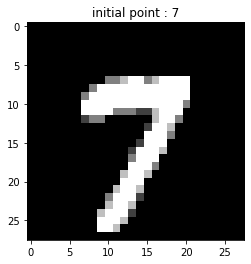

In [73]:
# initial point
initial_idx = 0
xc = X_train[initial_idx, :]
yc = y_train[initial_idx]

plt.imshow(xc.reshape(28,28),cmap='gray')
plt.title(f"initial point : {yc}")
plt.show()

In [74]:
train_idx = random.sample(list(range(1, X_train.shape[0]))
                          , 100)
X_train_ = copy.copy(X_train[train_idx,:])
y_train_ = copy.copy(y_train[train_idx])

y_train_ = np.where(y_train_ == '7', 1, -1)
y_valid_ = np.where(y_valid == '7', 1, -1)

In [75]:
attacker = Poison_attack_sklearn(clf,X_train_, y_train_, t=0.5)

xc_attacked, log = attacker.attack(xc, 1, X_valid, y_valid_, num_iterations=200)

100%|██████████| 200/200 [00:09<00:00, 20.47it/s]


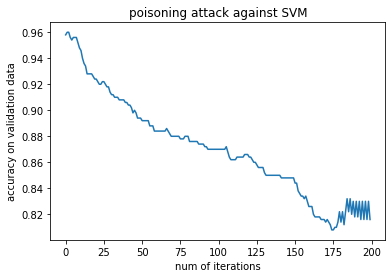

In [76]:
plt.plot(log)
plt.title("poisoning attack against SVM")
plt.xlabel("num of iterations")
plt.ylabel("accuracy on validation data")
plt.savefig("poison_loss.png")
plt.show()

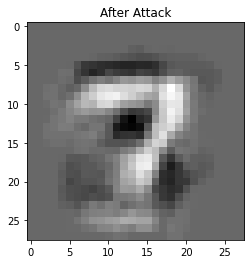

In [77]:
plt.imshow(xc_attacked.reshape(28,28),cmap='gray')
plt.title("After Attack")
plt.savefig("poison_example.png")
plt.show()

In [78]:
clf = SVC(kernel="linear", C=1)
clf.fit(X_train_, y_train_)
print("before attack: ", clf.score(X_valid, y_valid_))

# add poinsoned data
clf = SVC(kernel="linear", C=1)
clf.fit(np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
             np.concatenate([y_train_, [-1]]))
print("after attack: ", clf.score(X_valid, y_valid_))

before attack:  0.964
after attack:  0.83
